### Table of Contents

* [Linear Regression](#part1)
    * [EDA](#section_1_1)
    

# Linear Regression <a class="anchor" id="part1"></a>
## EDA <a class="anchor" id="section_1_1"></a>

### Project Description:
Using Hyundai Heavy Industries ships datasets, build a model that will predict the number of crew members a ship will require.
Data description: Measurements of ship tonnage (1000s), length(100's ft), passengers (100s), cabins (100s), crew (100s), and age for 158 cruise ships.

In [1]:
#imports

from pyspark.sql import SparkSession
import pandas as pd
from pyspark.ml.regression import LinearRegression

from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [2]:
spark = SparkSession.builder.appName("Ship_Regression").getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/15 15:42:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
ship_data = spark.read.csv('/Users/test/Desktop/Data_Science/Apache Spark/Python-and-Spark-for-Big-Data-master/\
Spark_for_Machine_Learning/Linear_Regression/cruise_ship_info.csv', inferSchema=True, header=True)

In [5]:
ship_data.show()

+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|  Ship_name|Cruise_line|Age|           Tonnage|passengers|length|cabins|passenger_density|crew|
+-----------+-----------+---+------------------+----------+------+------+-----------------+----+
|    Journey|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|      Quest|    Azamara|  6|30.276999999999997|      6.94|  5.94|  3.55|            42.64|3.55|
|Celebration|   Carnival| 26|            47.262|     14.86|  7.22|  7.43|             31.8| 6.7|
|   Conquest|   Carnival| 11|             110.0|     29.74|  9.53| 14.88|            36.99|19.1|
|    Destiny|   Carnival| 17|           101.353|     26.42|  8.92| 13.21|            38.36|10.0|
|    Ecstasy|   Carnival| 22|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Elation|   Carnival| 15|            70.367|     20.52|  8.55|  10.2|            34.29| 9.2|
|    Fantasy|   Carnival| 23| 

In [6]:
ship_data.printSchema()
#from what we can see all data is in integer format except ship name and cruise line. 
#Ship name does not have predictive value as it's arbitrary, we will not be using it in our model.

root
 |-- Ship_name: string (nullable = true)
 |-- Cruise_line: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tonnage: double (nullable = true)
 |-- passengers: double (nullable = true)
 |-- length: double (nullable = true)
 |-- cabins: double (nullable = true)
 |-- passenger_density: double (nullable = true)
 |-- crew: double (nullable = true)



In [7]:
#checking for Nan values - there is none which makes it much easier to work with
from pyspark.sql.functions import isnan, when, count, col
ship_data.select([count(when(isnan(c), c)).alias(c) for c in ship_data.columns]).show()

+---------+-----------+---+-------+----------+------+------+-----------------+----+
|Ship_name|Cruise_line|Age|Tonnage|passengers|length|cabins|passenger_density|crew|
+---------+-----------+---+-------+----------+------+------+-----------------+----+
|        0|          0|  0|      0|         0|     0|     0|                0|   0|
+---------+-----------+---+-------+----------+------+------+-----------------+----+



In [8]:
# checking what values we can find in "Cruis_Line" column
ship_data.select(ship_data['Cruise_Line']).distinct().show()

+-----------------+
|      Cruise_Line|
+-----------------+
|            Costa|
|              P&O|
|           Cunard|
|Regent_Seven_Seas|
|              MSC|
|         Carnival|
|          Crystal|
|           Orient|
|         Princess|
|        Silversea|
|         Seabourn|
| Holland_American|
|         Windstar|
|           Disney|
|        Norwegian|
|          Oceania|
|          Azamara|
|        Celebrity|
|             Star|
|  Royal_Caribbean|
+-----------------+



In [9]:
#stats for numeric columns:
num_cols = ship_data.select(ship_data.columns[2:])
for col in num_cols.columns:
    ship_data.describe(col).show()
#from the stats below we can see that there is a big difference in max/min values of tonnage - we may need 
#to treat them as outliers. There is also a difference in scale. We will fix this by normalizing data

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|               158|
|   mean|15.689873417721518|
| stddev| 7.615691058751413|
|    min|                 4|
|    max|                48|
+-------+------------------+

+-------+------------------+
|summary|           Tonnage|
+-------+------------------+
|  count|               158|
|   mean| 71.28467088607599|
| stddev|37.229540025907866|
|    min|             2.329|
|    max|             220.0|
+-------+------------------+

+-------+-----------------+
|summary|       passengers|
+-------+-----------------+
|  count|              158|
|   mean|18.45740506329114|
| stddev|9.677094775143416|
|    min|             0.66|
|    max|             54.0|
+-------+-----------------+

+-------+-----------------+
|summary|           length|
+-------+-----------------+
|  count|              158|
|   mean|8.130632911392404|
| stddev|1.793473548054825|
|    min|             2.79|
|    max|            11.82|

In [10]:
num_cols = num_cols.sample(False, 0.8).toPandas()

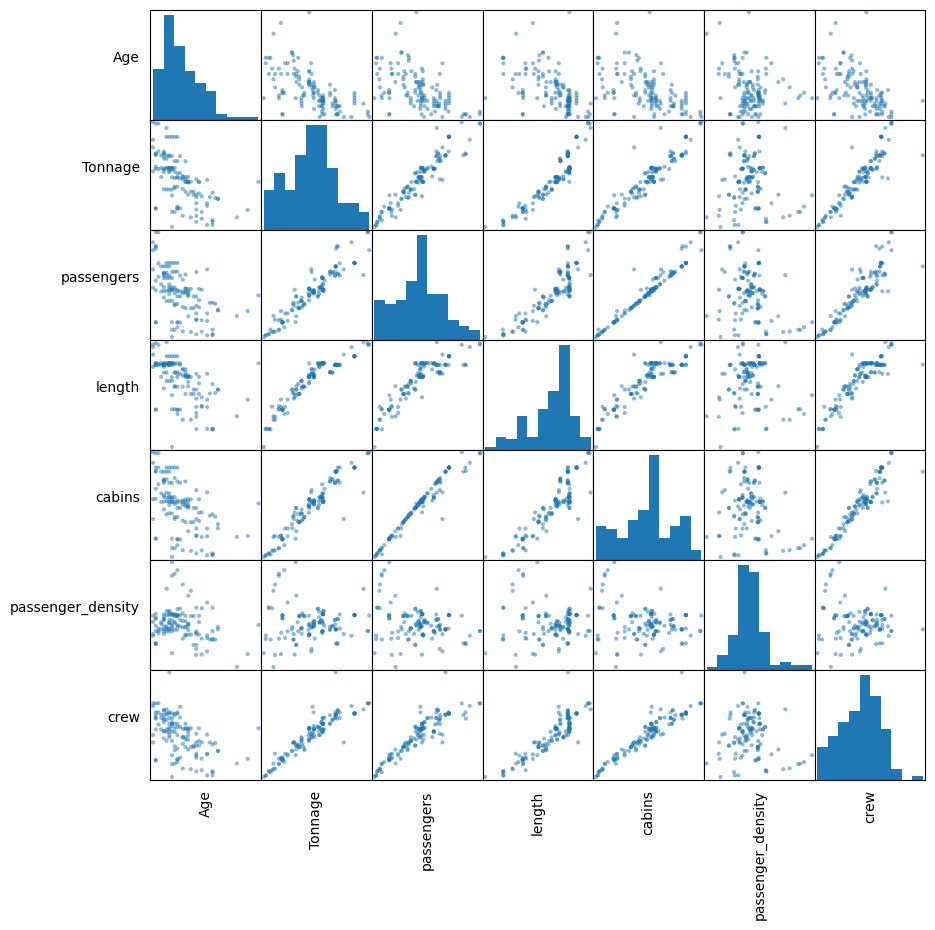

In [11]:
#investigating if relationship between dependent variable and numerical features is linear:
from pandas.plotting import scatter_matrix
axs = scatter_matrix(num_cols, figsize=(10, 10))
n = len(num_cols.columns)
for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

In [12]:
#from what we can see, all features have a linear relationship with the target, except passenger_density
#we will assess if there is correlation using Spearman's coefficient, since the relatioship is non-linear
from pyspark.mllib.stat import Statistics


# Compute the correlation using Pearson's method. Enter "spearman" for Spearman's method. If a 
# method is not specified, Pearson's method will be used by default. 

In [13]:
corr_df = num_cols[['crew', 'passenger_density']]
corr_df = spark.createDataFrame(corr_df)

/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:474: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():
/opt/anaconda3/envs/pyspark/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:486: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [14]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
vector_col = 'corr_feat'
assembler = VectorAssembler(inputCols=corr_df.columns, outputCol=vector_col)
df_vector = assembler.transform(corr_df).select(vector_col)

In [15]:
matrix = Correlation.corr(df_vector, vector_col, method = 'spearman')
corr_mtx = matrix.collect()[0][matrix.columns[0]].toArray()
corr_mtx
#from what we can see, there is not much correlation between passenger density and # 
#of crew members, we can remove this feature

22/12/15 15:43:14 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/15 15:43:14 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


array([[1.        , 0.00102318],
       [0.00102318, 1.        ]])

In [57]:
#convert string values into integers:
from pyspark.ml.feature import StringIndexer, OneHotEncoder
cruise_num = StringIndexer(inputCol = 'Cruise_Line', outputCol = 'cruise_num').fit(anova_df)
anova_df = cruise_num.transform(anova_df)
anova_df.show()

+-----------+----+----------+
|Cruise_Line|crew|cruise_num|
+-----------+----+----------+
|    Azamara|3.55|      16.0|
|    Azamara|3.55|      16.0|
|   Carnival| 6.7|       1.0|
|   Carnival|19.1|       1.0|
|   Carnival|10.0|       1.0|
|   Carnival| 9.2|       1.0|
|   Carnival| 9.2|       1.0|
|   Carnival| 9.2|       1.0|
|   Carnival| 9.2|       1.0|
|   Carnival|11.5|       1.0|
|   Carnival|11.6|       1.0|
|   Carnival| 6.6|       1.0|
|   Carnival| 9.2|       1.0|
|   Carnival| 9.2|       1.0|
|   Carnival| 9.3|       1.0|
|   Carnival|11.6|       1.0|
|   Carnival|10.3|       1.0|
|   Carnival| 9.2|       1.0|
|   Carnival| 9.3|       1.0|
|   Carnival| 9.2|       1.0|
+-----------+----+----------+
only showing top 20 rows



In [ ]:
encoder = OneHotEncoder(inputCol = 'cruise_num', outputCol = 'cruise_encoded').fit(anova_df)
encoded_df = encoder.transform(anova_df)
encoded_df.show()